# **Generazione di dataset sintetici con diversi livelli di privacy: no privacy, privacy moderata e privacy strong**

Determinareil trade-off tra livello di privacy e l'effettiva utilità del dataset sintetico

In [ ]:
#SALVA TUTTE LE CARTELLE E FILE
!zip -r all_colab_files.zip /content

from google.colab import files
files.download("all_colab_files.zip")

In [ ]:
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu121

In [ ]:
import torch
if torch.cuda.is_available():
    print(f"GPU rilevata: {torch.cuda.get_device_name(0)}")
else:
    print("GPU NON rilevata. Controlla le impostazioni del Runtime.")

GPU rilevata: Tesla T4


In [ ]:
!pip install --quiet sdv==1.29.1

!pip install --quiet ctgan==0.11.1

!pip install smartnoise-synth==1.0.5

!pip install --quiet xgboost joblib


In [3]:
import os
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import evaluate_quality

from sdv.evaluation.single_table import evaluate_quality, run_diagnostic, get_column_plot

from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Crea le directory se non esistono
os.makedirs("dataset/real", exist_ok=True)
os.makedirs("dataset/synthetic", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [6]:
#Carica dati già fatti
train_df  = pd.read_csv("dataset/real/diabetes_train.csv")
holdout_df = pd.read_csv("dataset/real/diabetes_holdout.csv")
df=train_df
synthetic_noprivacy = pd.read_csv("dataset/synthetic/synthetic_no_privacy.csv")
metadata_noprivacy = SingleTableMetadata()
metadata_noprivacy.detect_from_dataframe(df)
synthetic_mod       = pd.read_csv("dataset/synthetic/synthetic_privacy_moderata.csv")
metadata_mod = SingleTableMetadata()
metadata_mod.detect_from_dataframe(df)
synthetic_strong    = pd.read_csv("dataset/synthetic/synthetic_privacy_strong.csv")
metadata_strong  = SingleTableMetadata()
metadata_strong.detect_from_dataframe(df)

In [ ]:
def carica_dataset():
    path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
    csv_path = os.path.join(path, "diabetes_binary_health_indicators_BRFSS2015.csv")
    df = pd.read_csv(csv_path)
    df = df.rename(columns={'Diabetes_binary': 'outcome'})
    print(f"Dataset caricato: {df.shape[0]} righe e {df.shape[1]} colonne")
    return df

def preprocessa_dataset(df):
    df = df.astype(float)
    df = df.astype('int64')

    return df

# Crea le directory se non esistono
os.makedirs("dataset/real", exist_ok=True)
os.makedirs("dataset/synthetic", exist_ok=True)
os.makedirs("models", exist_ok=True)

df = carica_dataset()
df = preprocessa_dataset(df)
df.info()

train_df, holdout_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['outcome']
)

train_df.to_csv('dataset/real/diabetes_train.csv', index=False)
holdout_df.to_csv('dataset/real/diabetes_holdout.csv', index=False)

print(f"Dimensione train: {train_df.shape}")
print(f"Dimensione holdout: {holdout_df.shape}")

Using Colab cache for faster access to the 'diabetes-health-indicators-dataset' dataset.
Dataset caricato: 253680 righe e 22 colonne
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   outcome               253680 non-null  int64
 1   HighBP                253680 non-null  int64
 2   HighChol              253680 non-null  int64
 3   CholCheck             253680 non-null  int64
 4   BMI                   253680 non-null  int64
 5   Smoker                253680 non-null  int64
 6   Stroke                253680 non-null  int64
 7   HeartDiseaseorAttack  253680 non-null  int64
 8   PhysActivity          253680 non-null  int64
 9   Fruits                253680 non-null  int64
 10  Veggies               253680 non-null  int64
 11  HvyAlcoholConsump     253680 non-null  int64
 12  AnyHealthcare         253680 non-null  int64
 13  N

## **GENERAZIONE DATI SINTETICI**

## NO PRIVACY

In [ ]:
def synthetic_no_privacy(df):

    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)

    for col in df.columns:
        if col in ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']:
            metadata.update_column(col, sdtype='numerical')
        else:
            metadata.update_column(col, sdtype='categorical')

    model = CTGANSynthesizer(
        metadata,
        epochs=50,
        batch_size=2000,
        generator_dim=(256, 256, 256),
        discriminator_dim=(256, 256, 256),
        verbose=True,
        pac=10,
        cuda=True
    )

    print("Inizio addestramento CTGAN su dataset CDC...")
    model.fit(df)

    num_samples = len(df)
    print(f"Generazione di {num_samples} campioni...")
    synthetic = model.sample(num_samples)

    os.makedirs("models", exist_ok=True)
    model.save("models/ctgan_no_privacy.pkl")

    return synthetic, metadata

synthetic_noprivacy, metadata_noprivacy = synthetic_no_privacy(train_df)
synthetic_noprivacy.to_csv('dataset/synthetic/synthetic_no_privacy.csv', index=False)

## CON PRIVACY

In [9]:
from snsynth import Synthesizer
import torch
import gc
import pickle

def synthetic_dpctgan(df, epsilon, model_path):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df)
    gc.collect()
    torch.cuda.empty_cache()

    use_cuda = torch.cuda.is_available()
    print(f"Device rilevato: {'cuda' if use_cuda else 'cpu'}")

    synth = Synthesizer.create(
        synth="dpctgan",
        epsilon=epsilon,
        epochs=300,
        batch_size=2000,
        verbose=True,
        cuda=use_cuda
    )

    print(f"Inizio training DP-CTGAN (ε={epsilon})...")

    synth.fit(df)

    df_synt = synth.sample(len(df))
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    with open(model_path, 'wb') as f:
        pickle.dump(synth, f)
    print(f"Modello salvato con successo in: {model_path}")

    return df_synt, metadata


In [10]:
# PRIVACY MODERATA
print("Generazione privacy moderata...")
synthetic_mod, metadata_mod = synthetic_dpctgan(train_df, epsilon=4.0,model_path="models/privacy_moderata.pkl")
synthetic_mod.to_csv("dataset/synthetic/synthetic_privacy_moderata.csv", index=False)

Generazione privacy moderata...
Device rilevato: cuda
Inizio training DP-CTGAN (ε=4.0)...
Epoch 1, Loss G: 0.6586, Loss D: 1.3983
epsilon is 0.21283664753187329, alpha is 63.0
Epoch 2, Loss G: 0.6866, Loss D: 1.3873
epsilon is 0.23869863329550584, alpha is 63.0
Epoch 3, Loss G: 0.6884, Loss D: 1.3848
epsilon is 0.26456061905913836, alpha is 63.0
Epoch 4, Loss G: 0.6845, Loss D: 1.3883
epsilon is 0.2904226048227709, alpha is 63.0
Epoch 5, Loss G: 0.6692, Loss D: 1.3940
epsilon is 0.3162845905864034, alpha is 63.0
Epoch 6, Loss G: 0.6806, Loss D: 1.3761
epsilon is 0.3421465763500359, alpha is 63.0
Epoch 7, Loss G: 0.6716, Loss D: 1.3927
epsilon is 0.36800856211366845, alpha is 63.0
Epoch 8, Loss G: 0.6715, Loss D: 1.3832
epsilon is 0.393870547877301, alpha is 63.0
Epoch 9, Loss G: 0.6682, Loss D: 1.3845
epsilon is 0.41973253364093355, alpha is 63.0
Epoch 10, Loss G: 0.6612, Loss D: 1.3884
epsilon is 0.44555709216861406, alpha is 62.0
Epoch 11, Loss G: 0.6623, Loss D: 1.3902
epsilon is 0.

In [38]:
# PRIVACY STRONG
print("Generazione privacy forte ...")
synthetic_strong, metadata_strong = synthetic_dpctgan(train_df, epsilon=0.1, model_path="models/privacy_strong.pkl")
synthetic_strong.to_csv("dataset/synthetic/synthetic_privacy_strong.csv", index=False)

Generazione privacy forte ...
Device rilevato: cuda
Inizio training DP-CTGAN (ε=0.1)...
Modello salvato con successo in: models/privacy_strong.pkl


### **VALUTAZIONE SOMIGLIANZA STATISTICA**

ANALISI QUALITA' DEI DATI SINTETICI

In [52]:
def valuta_qualita_dataset(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI QUALITÀ: {nome} =====")

    # 1) DIAGNOSTICA
    print("\n--- Diagnostic Report ---")
    diagnostic = run_diagnostic(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata
    )

    # 2) QUALITY REPORT
    quality_report = evaluate_quality(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata,
        verbose=False
    )
    print("\n--- Quality Score ---")
    print(quality_report.get_score())

    return diagnostic, quality_report

datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA", synthetic_mod, metadata_mod),
    ("PRIVACY STRONG", synthetic_strong, metadata_strong)
]

diagnostics = {}
quality_reports = {}

for nome, synth_df, meta in datasets_sintetici:
    diag, q_report = valuta_qualita_dataset(df, synth_df, meta, nome)
    diagnostics[nome] = diag
    quality_reports[nome] = q_report



===== ANALISI QUALITÀ: NO PRIVACY =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 22/22 [00:00<00:00, 198.70it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 257.00it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%


--- Quality Score ---
0.8757999688295826

===== ANALISI QUALITÀ: PRIVACY MODERATA =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 22/22 [00:00<00:00, 168.44it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 364.22it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%


--- Quality Score ---
0.8939904409275443

===== ANALISI QUALITÀ: PRIVACY STRONG =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 22/22 [00:00<00:00, 186.46it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure:

ANALISI SOMIGLIANZA STATISTICA DEI DATI SINTETICI


===== ANALISI SOMIGLIANZA STATISTICA: NO PRIVACY =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
outcome                            0.1393           0.2320       0.0926
HighBP                             0.4290           0.5762       0.1472
HighChol                           0.4243           0.5773       0.1530
CholCheck                          0.9624           0.9600      -0.0024
BMI                               28.3780          29.6326       1.2546
Smoker                             0.4429           0.5933       0.1505
Stroke                             0.0404           0.0511       0.0107
HeartDiseaseorAttack               0.0942           0.1401       0.0459
PhysActivity                       0.7570           0.7954       0.0384
Fruits                             0.6344           0.7035       0.0691
Veggies                            0.8114           0.8526       0.0412
HvyAlcoholConsump                 

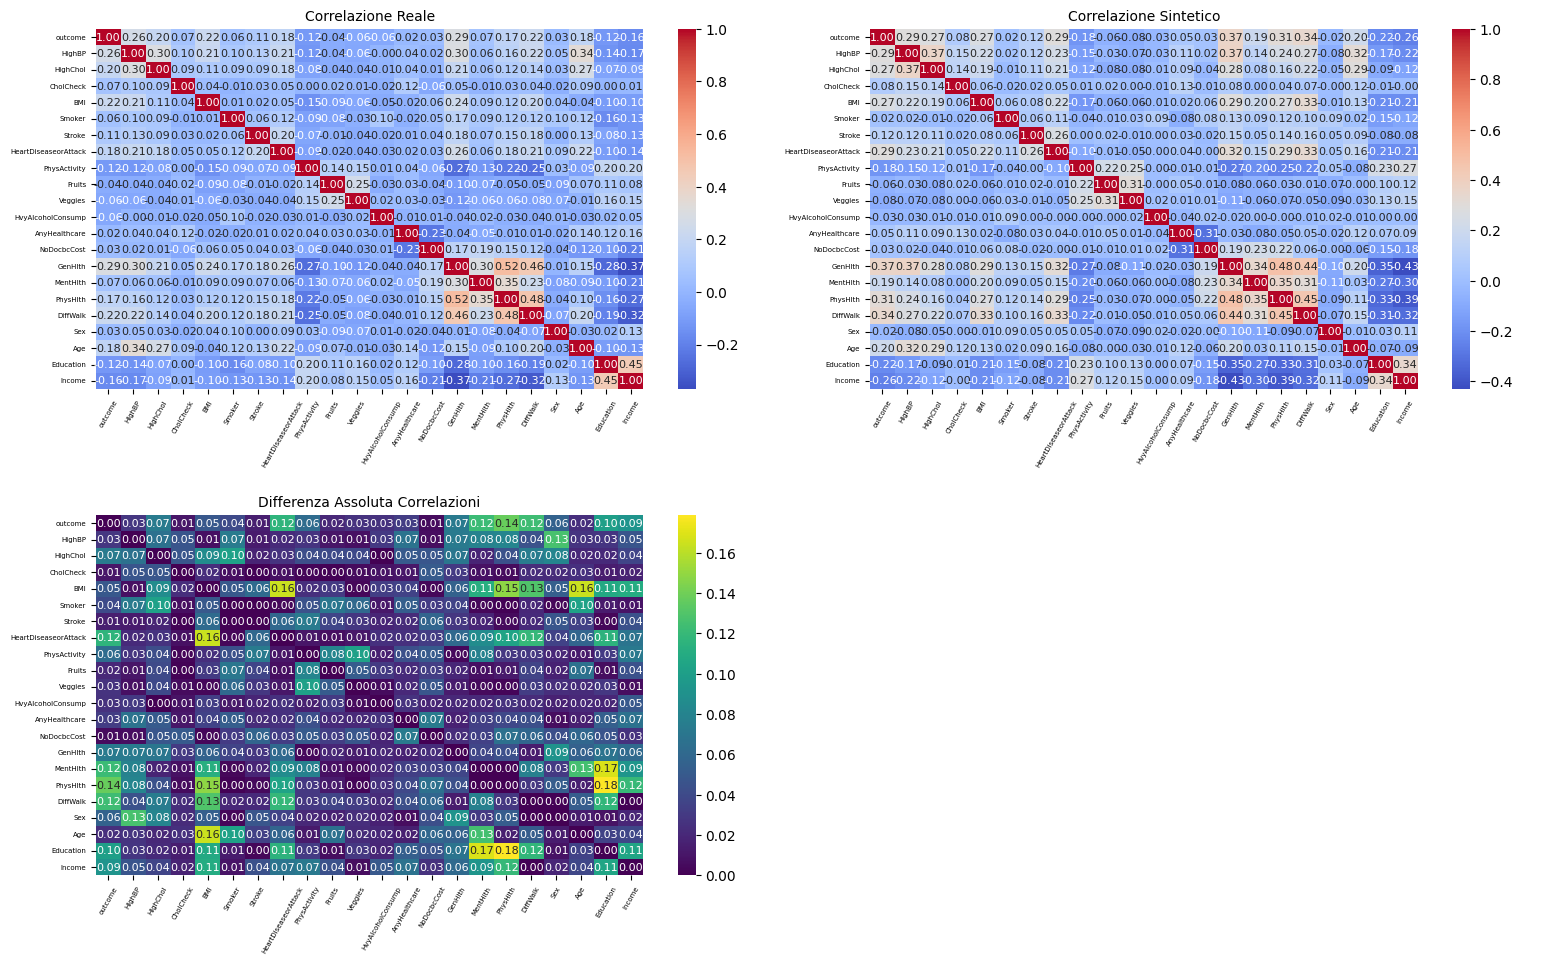

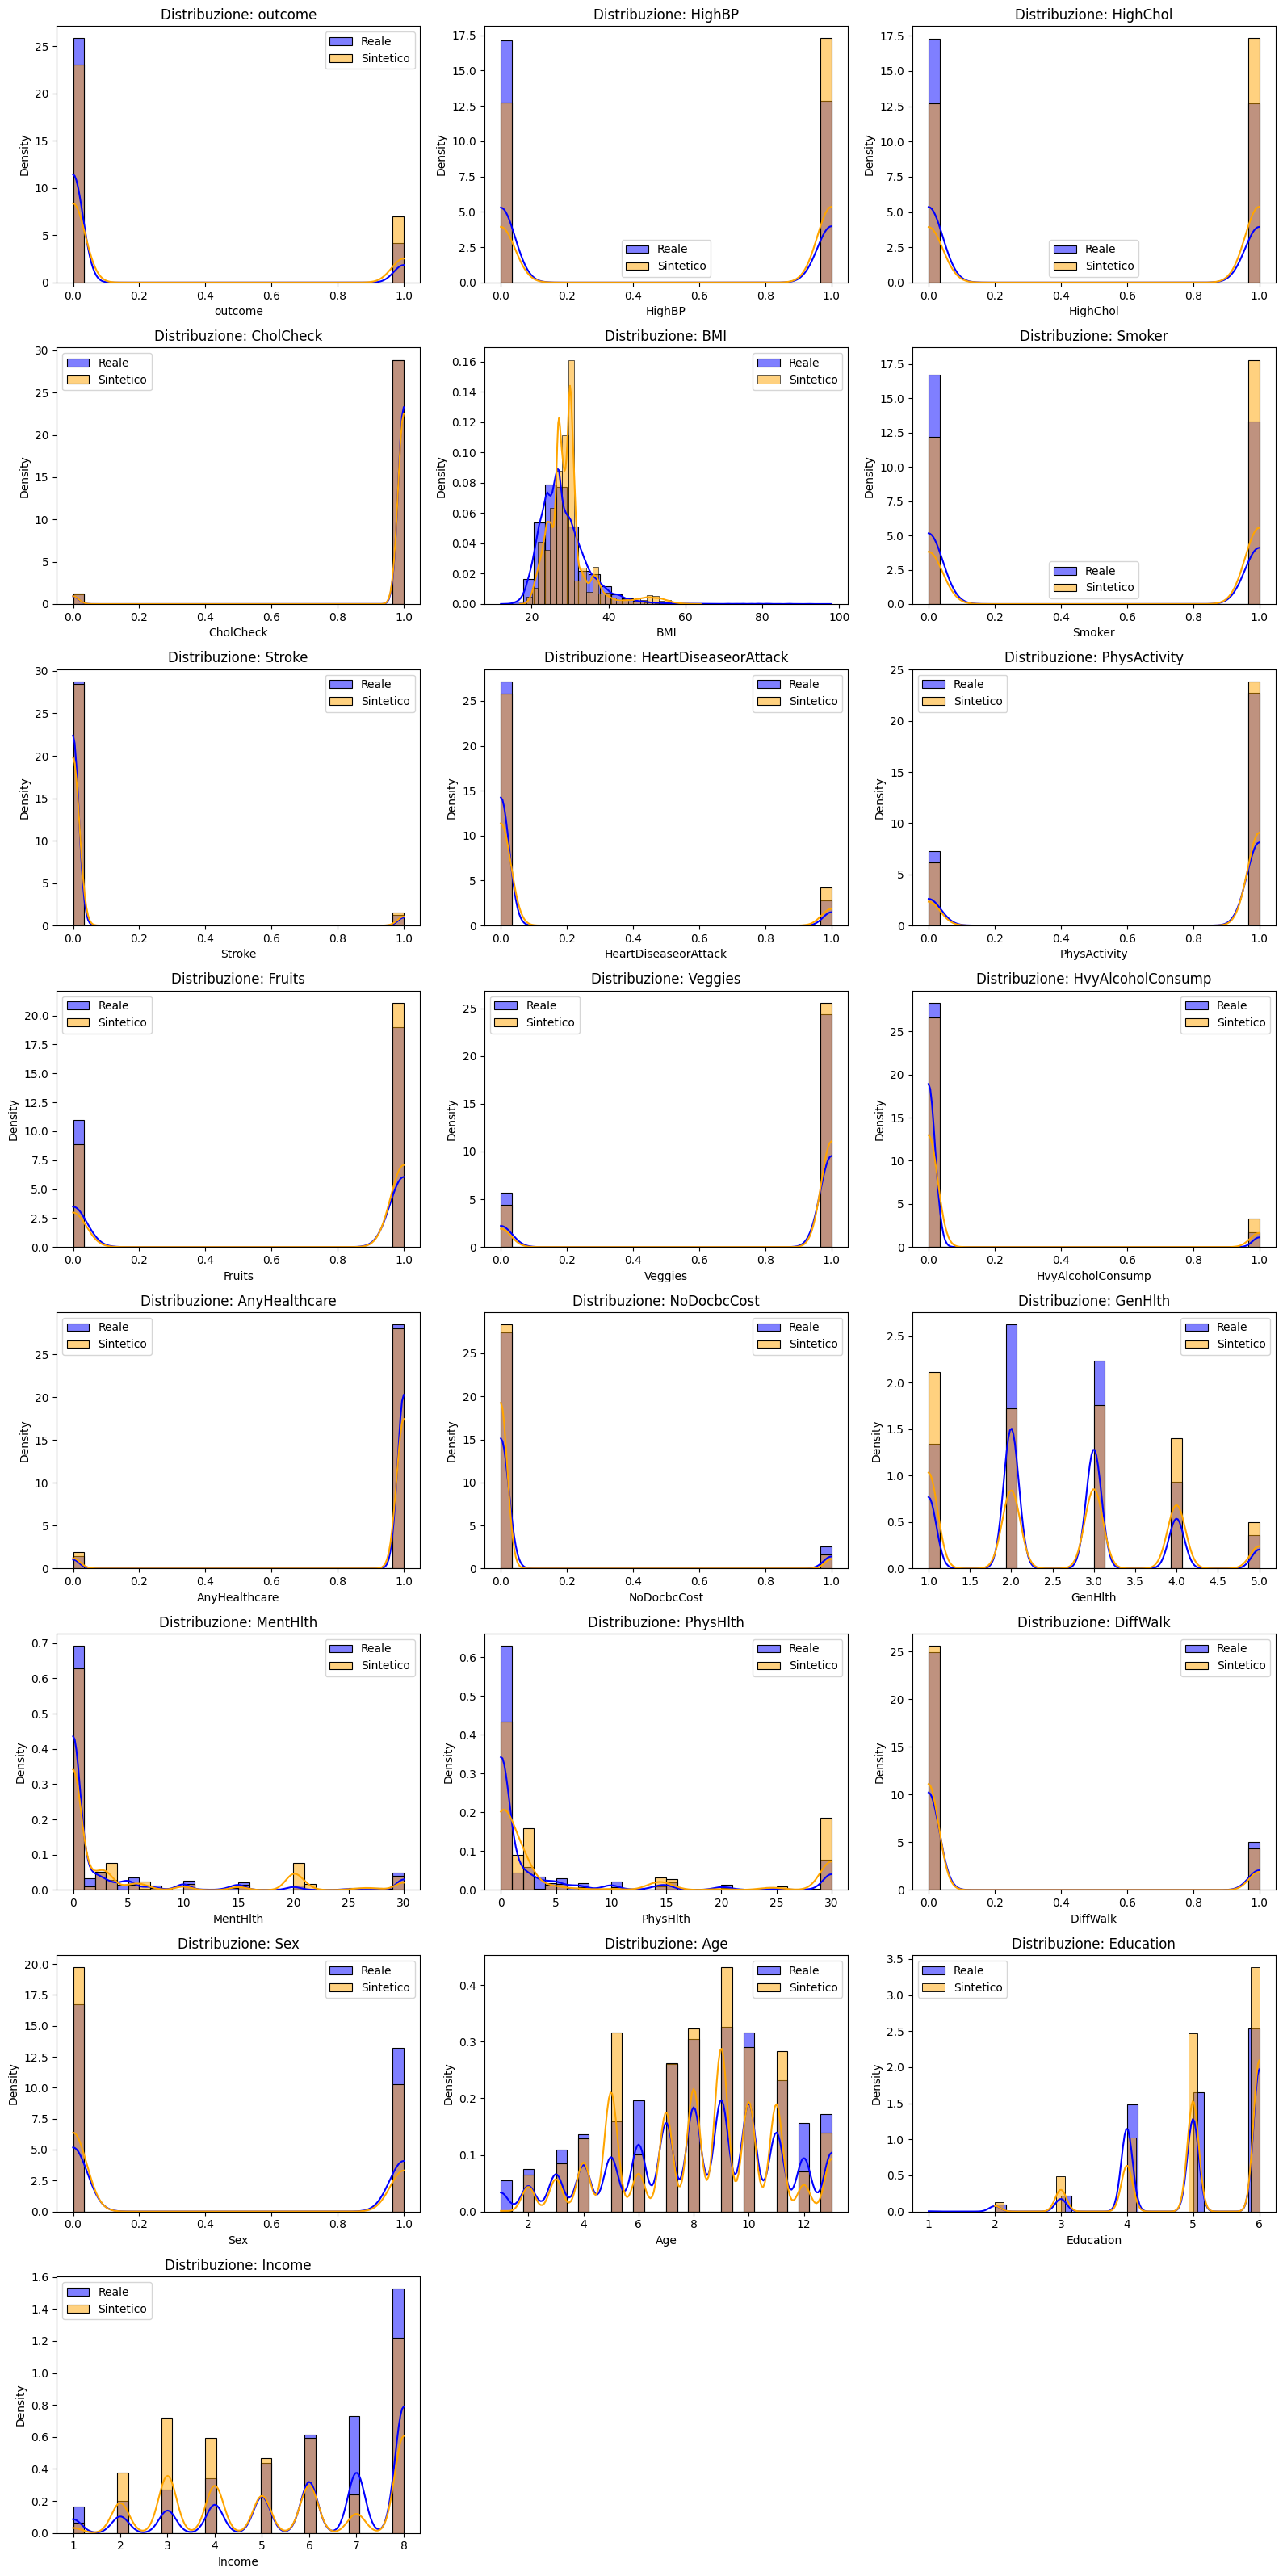


Test di similarità distribuzionale (Wasserstein e Jensen-Shannon):
Feature                           Wasserstein       Jensen-Shannon
outcome                                0.0926               0.0072
HighBP                                 0.1472               0.0109
HighChol                               0.1530               0.0117
CholCheck                              0.0024               0.0000
BMI                                    1.6197               0.1293
Smoker                                 0.1505               0.0114
Stroke                                 0.0107               0.0003
HeartDiseaseorAttack                   0.0459               0.0026
PhysActivity                           0.0384               0.0011
Fruits                                 0.0691               0.0027
Veggies                                0.0412               0.0015
HvyAlcoholConsump                      0.0558               0.0052
AnyHealthcare                          0.0158               0

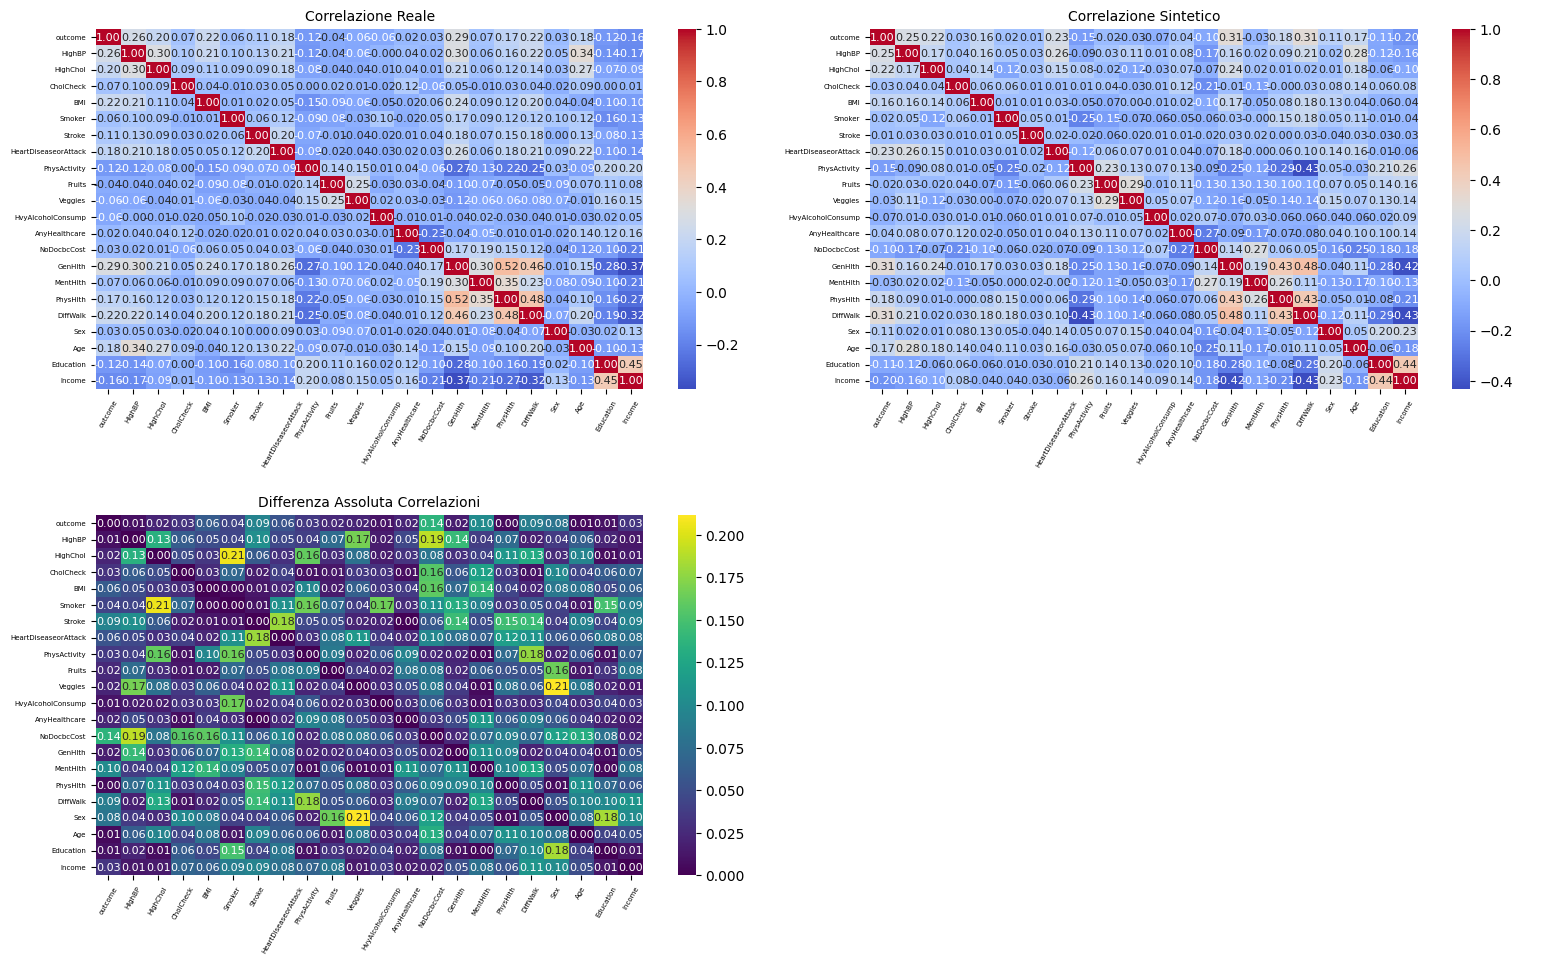

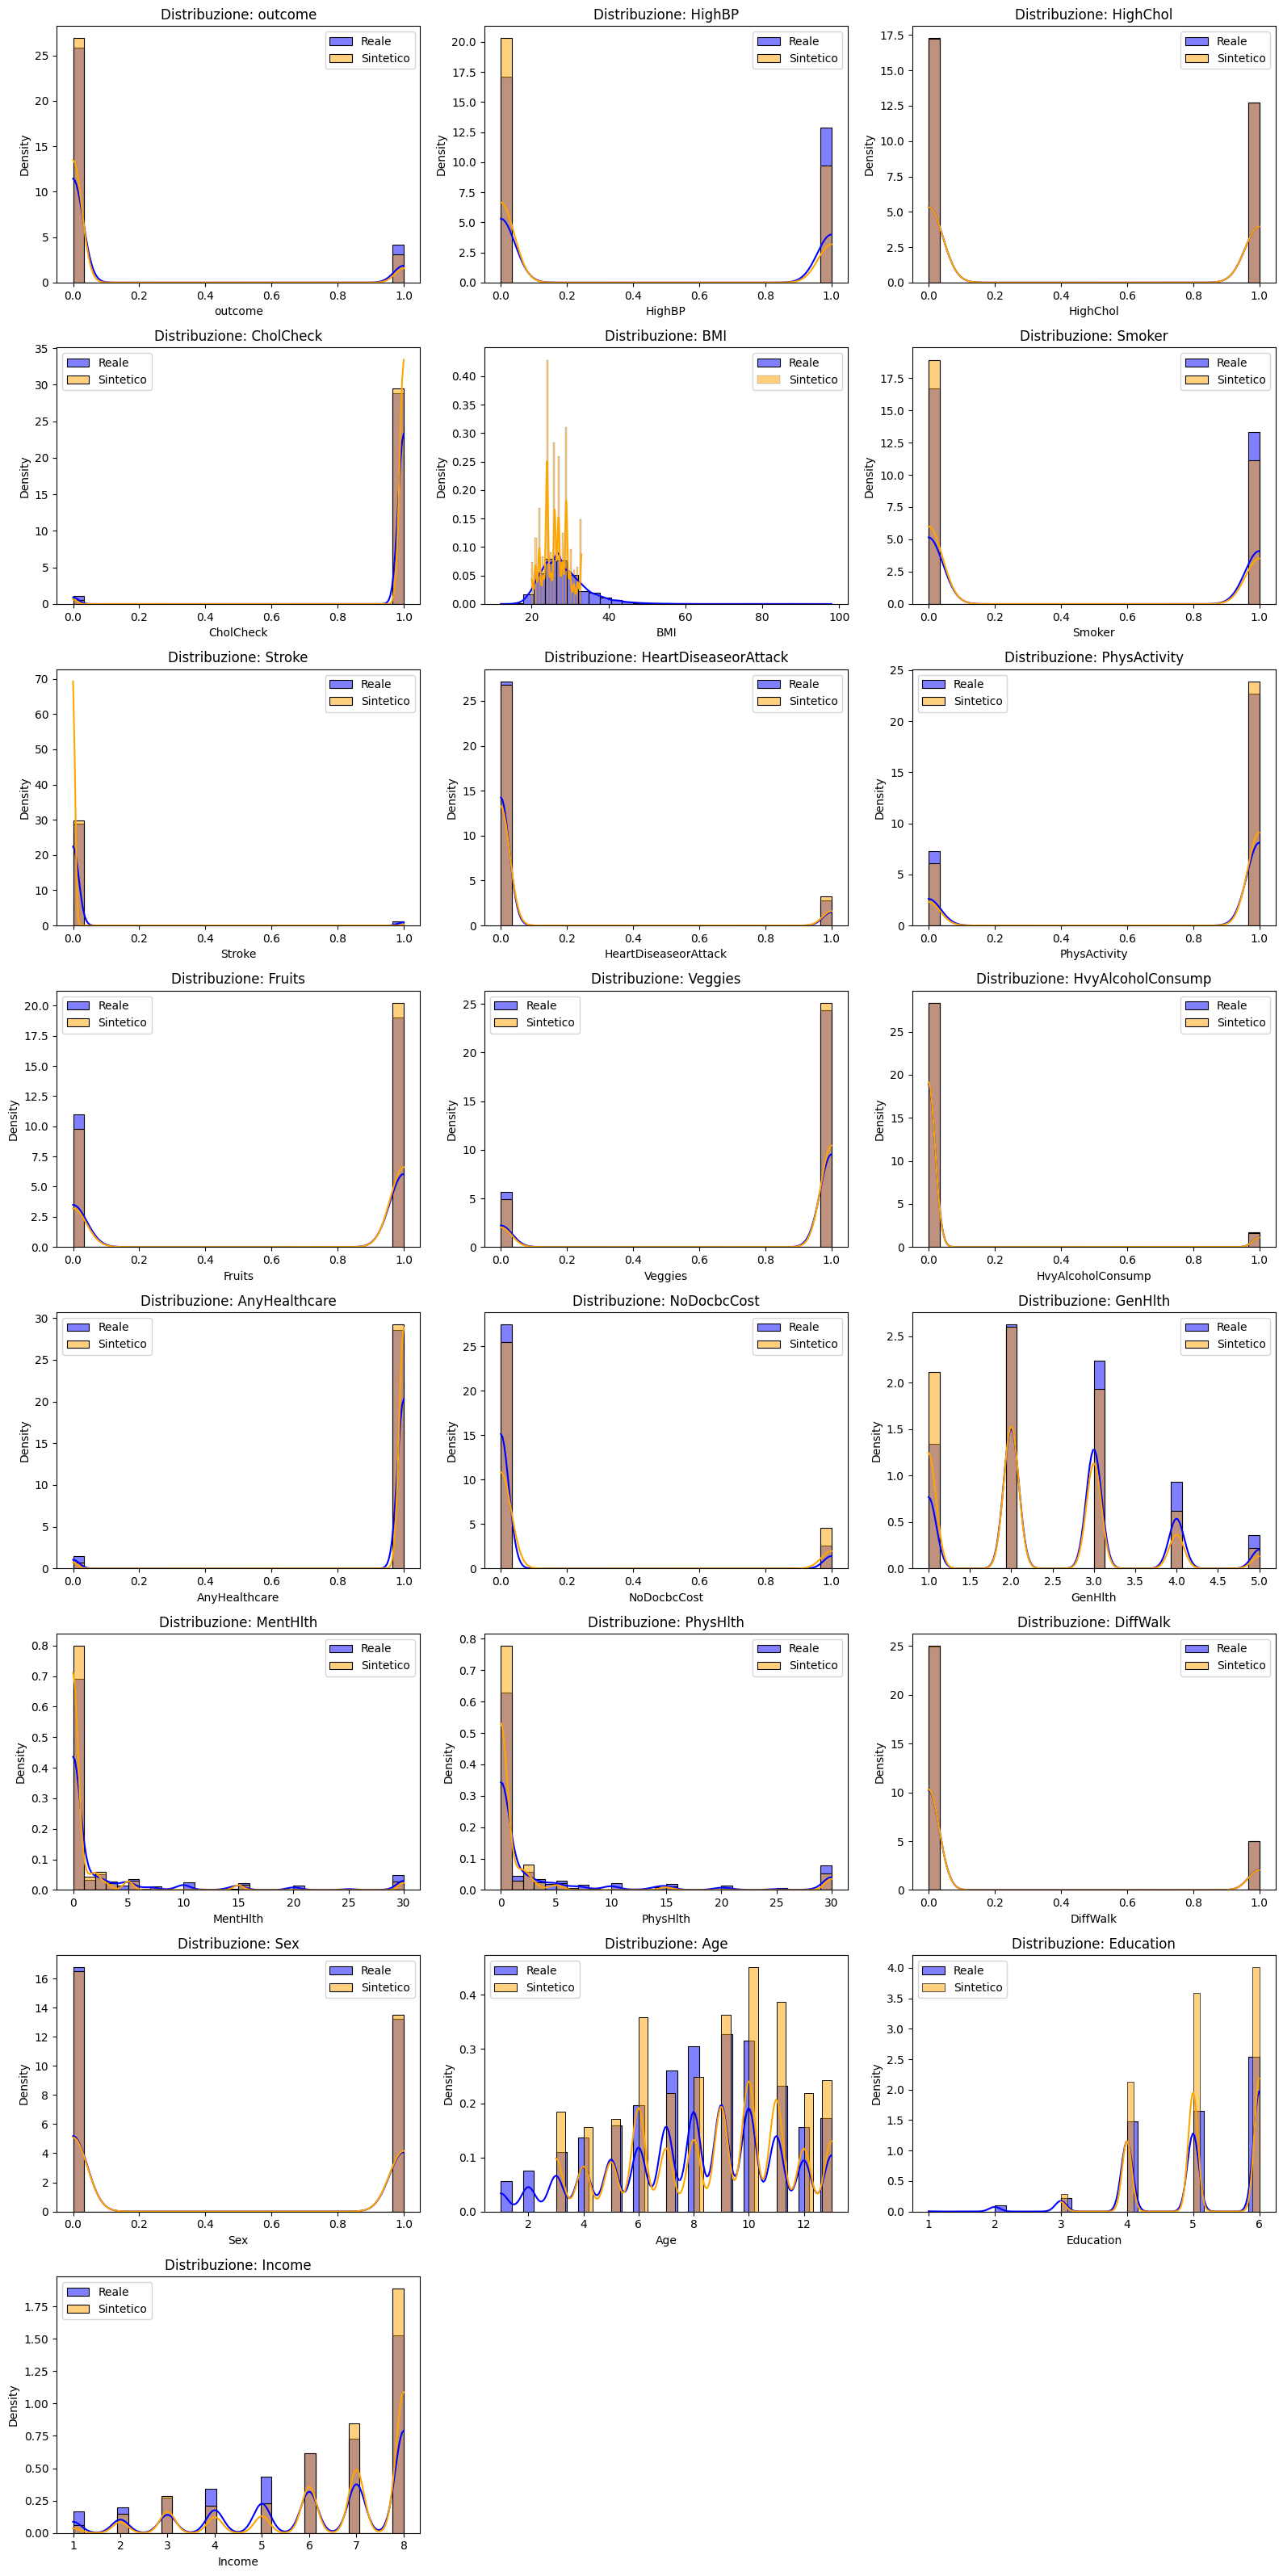


Test di similarità distribuzionale (Wasserstein e Jensen-Shannon):
Feature                           Wasserstein       Jensen-Shannon
outcome                                0.0353               0.0015
HighBP                                 0.1052               0.0059
HighChol                               0.0007               0.0000
CholCheck                              0.0190               0.0017
BMI                                    2.2823               0.5391
Smoker                                 0.0730               0.0028
Stroke                                 0.0360               0.0085
HeartDiseaseorAttack                   0.0129               0.0002
PhysActivity                           0.0399               0.0012
Fruits                                 0.0400               0.0009
Veggies                                0.0259               0.0006
HvyAlcoholConsump                      0.0011               0.0000
AnyHealthcare                          0.0241               0

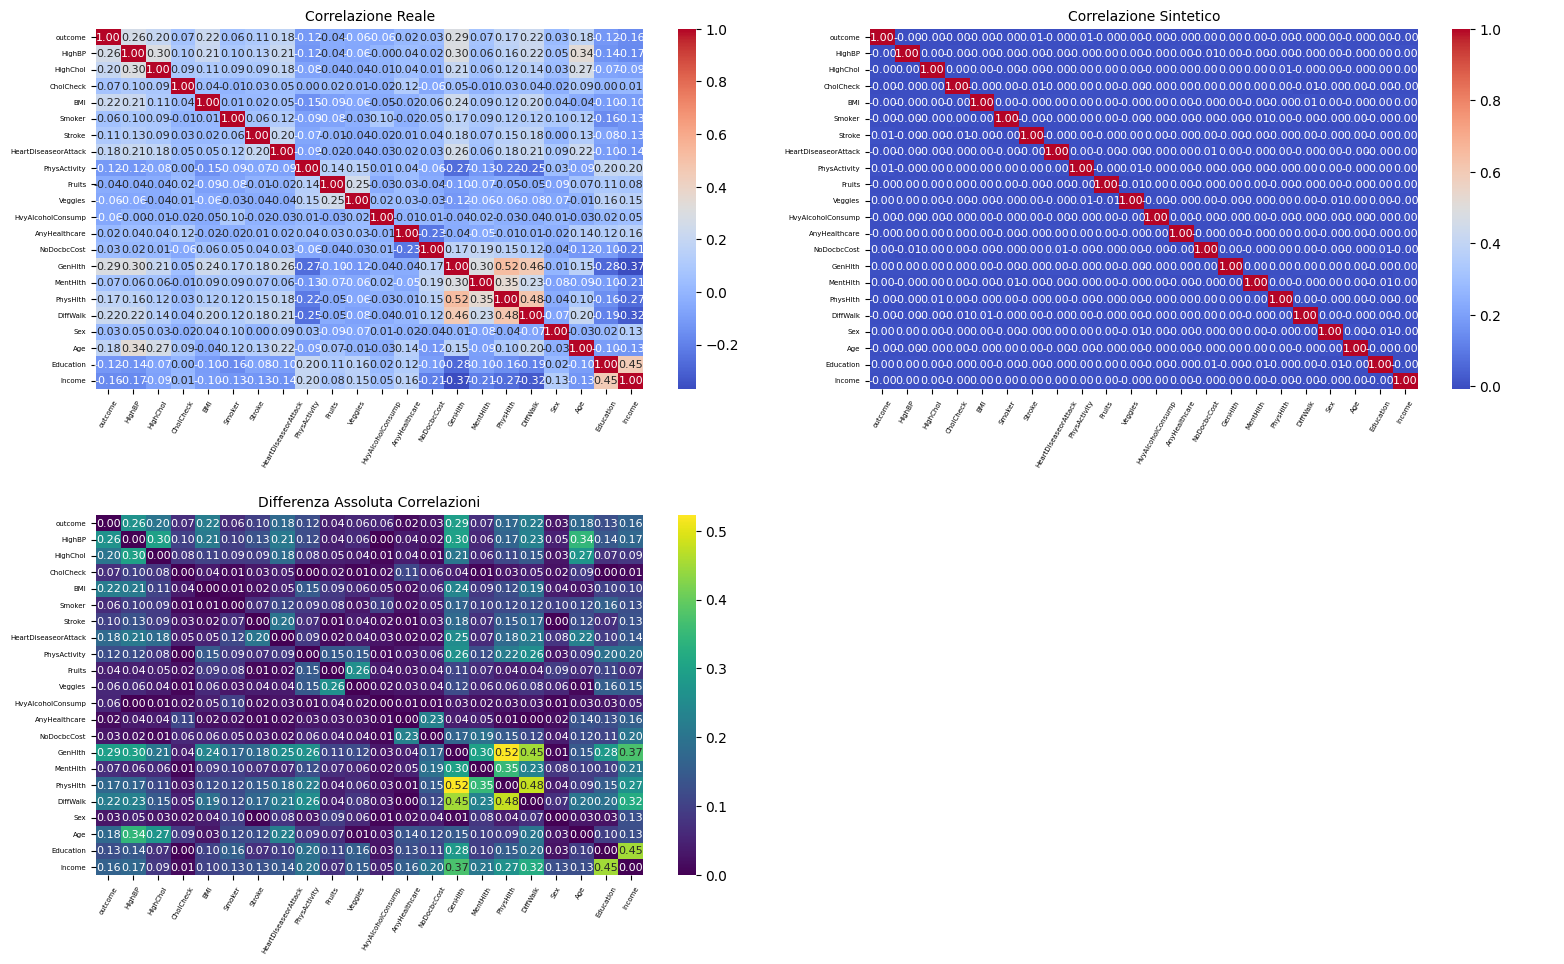

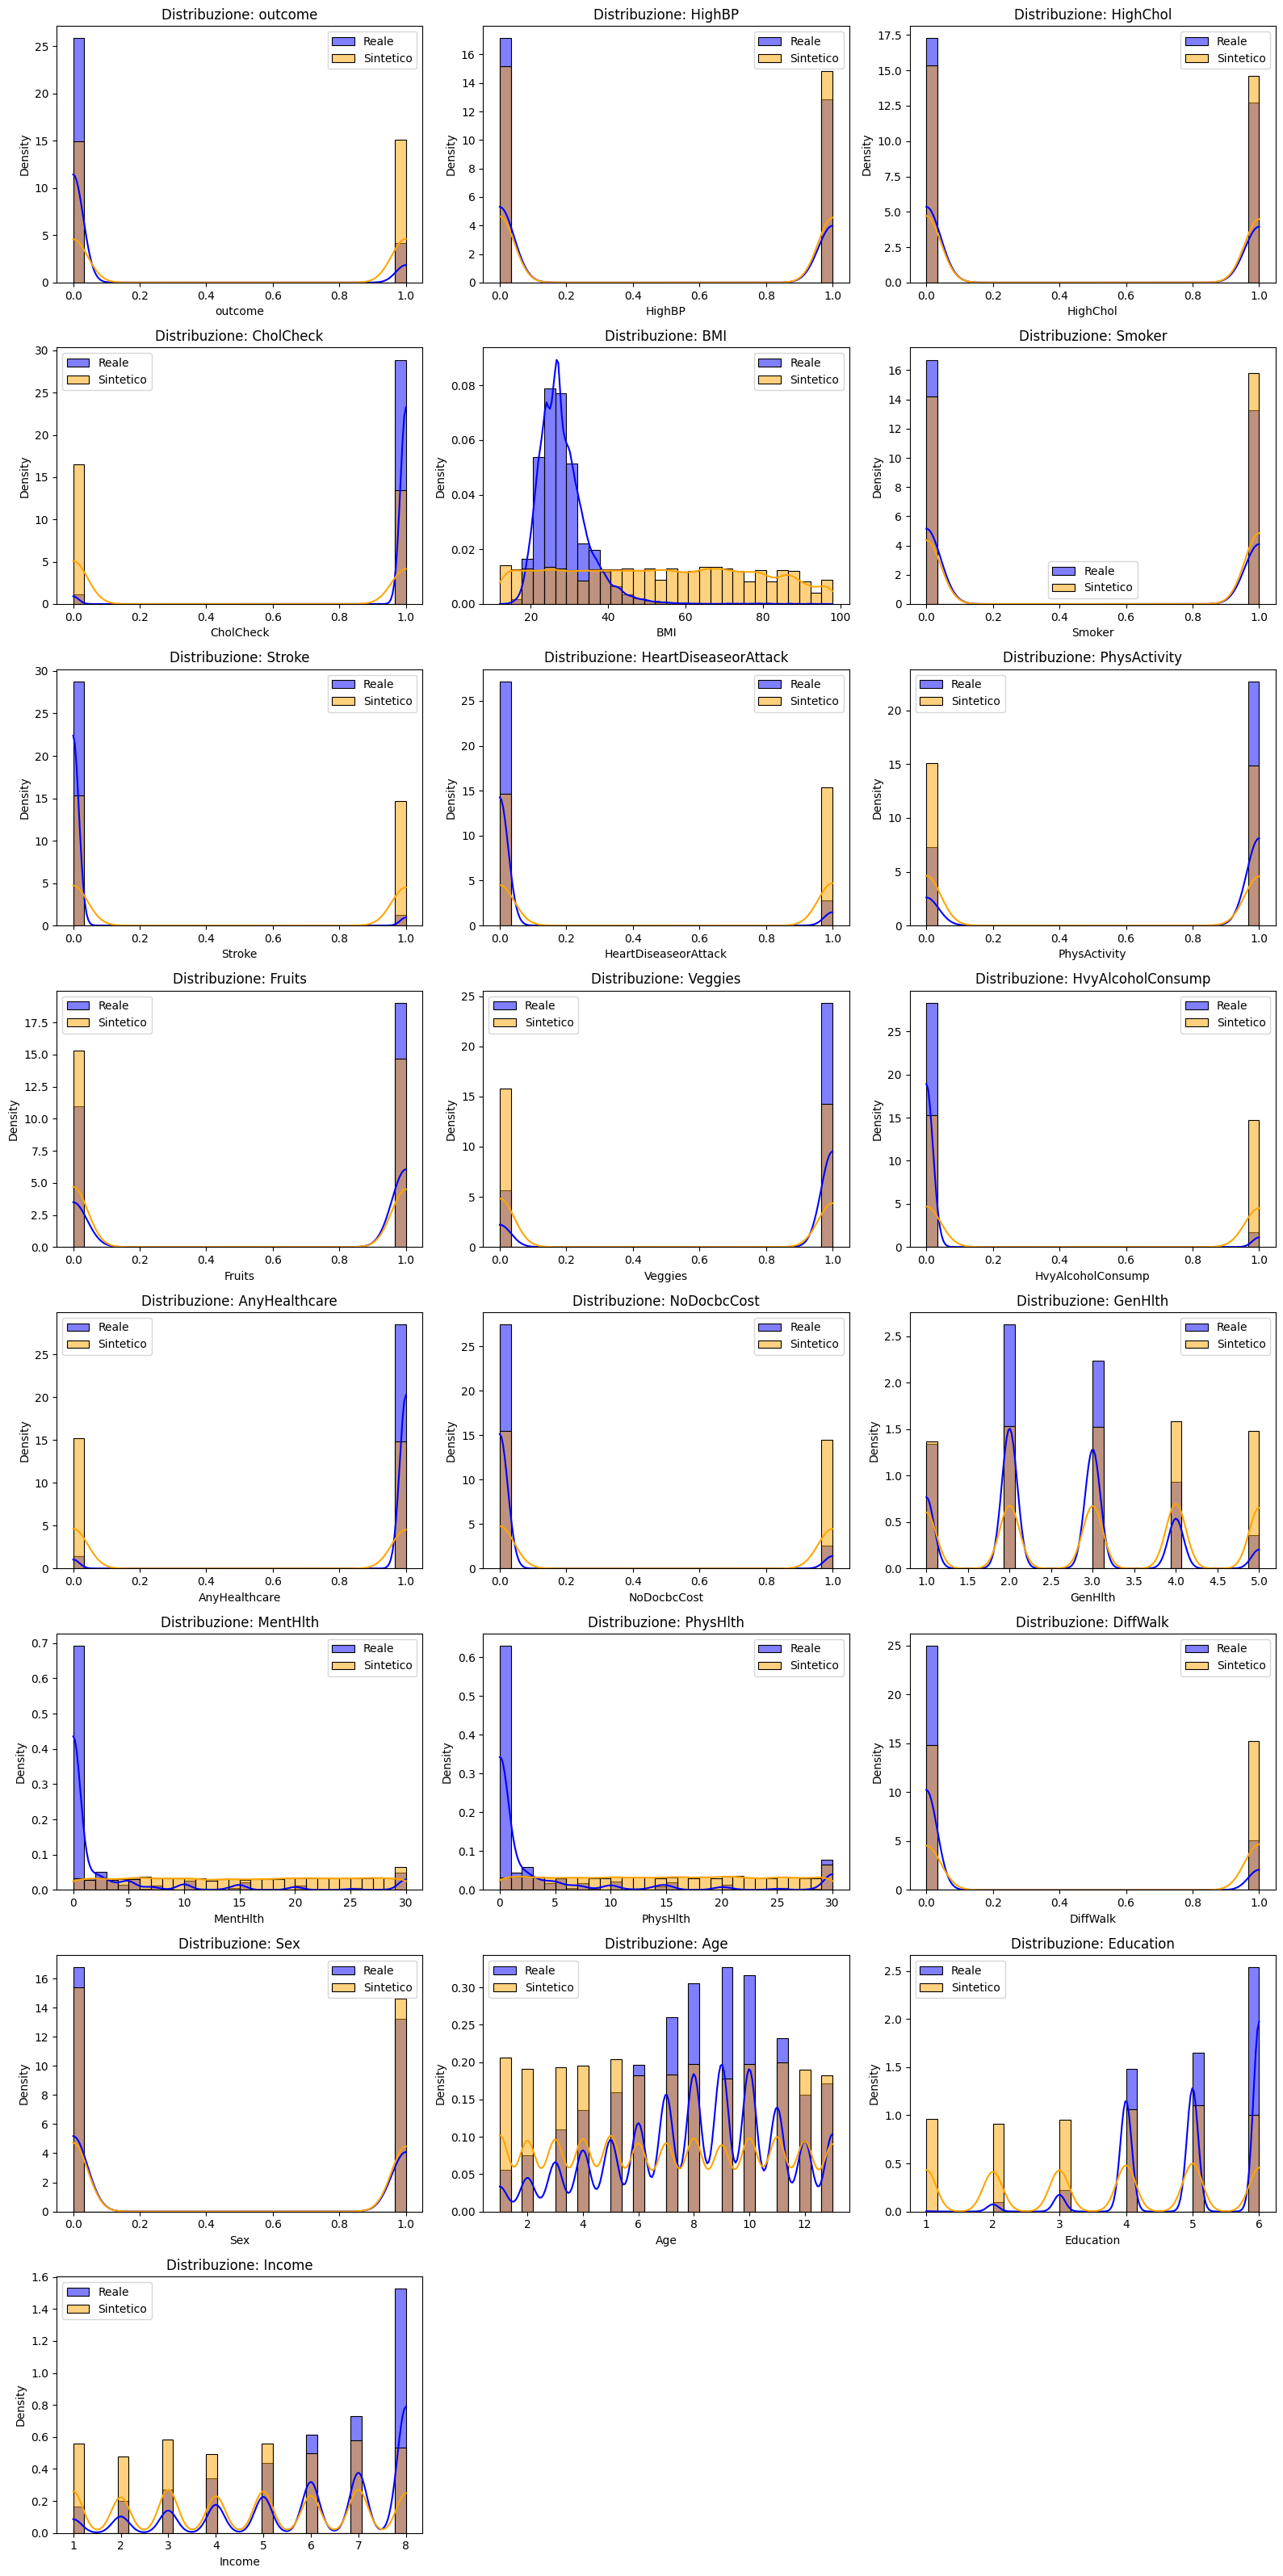


Test di similarità distribuzionale (Wasserstein e Jensen-Shannon):
Feature                           Wasserstein       Jensen-Shannon
outcome                                0.3631               0.0791
HighBP                                 0.0662               0.0022
HighChol                               0.0635               0.0020
CholCheck                              0.5129               0.1816
BMI                                   25.0876               0.3165
Smoker                                 0.0835               0.0035
Stroke                                 0.4475               0.1463
HeartDiseaseorAttack                   0.4175               0.1108
PhysActivity                           0.2606               0.0369
Fruits                                 0.1455               0.0108
Veggies                                0.3367               0.0636
HvyAlcoholConsump                      0.4338               0.1319
AnyHealthcare                          0.4576               0

In [53]:
from scipy.stats import ks_2samp, ttest_ind, levene, chi2_contingency
from scipy.stats import wasserstein_distance, entropy

def jensen_shannon(p, q, bins=50):
        p_hist, _ = np.histogram(p, bins=bins, density=True)
        q_hist, _ = np.histogram(q, bins=bins, density=True)
        p_prob = p_hist / np.sum(p_hist)
        q_prob = q_hist / np.sum(q_hist)
        m = 0.5 * (p_prob + q_prob)
        return 0.5 * (entropy(p_prob, m) + entropy(q_prob, m))

def somiglianza_statistica(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI SOMIGLIANZA STATISTICA: {nome} =====")

    num_cols = [col for col in real.columns if pd.api.types.is_numeric_dtype(real[col])]
    cat_cols = [col for col in real.columns if pd.api.types.is_categorical_dtype(real[col])
                or real[col].nunique() < 20]
    print("\nConfronto delle medie tra reale e sintetico:")
    print("{:<28} {:>12} {:>16} {:>12}".format('Feature', 'Mean Real', 'Mean Synthetic', 'Diff'))
    for col in num_cols:
        mean_real = real[col].mean()
        mean_synth = synth[col].mean()
        diff = mean_synth - mean_real
        print("{:<28} {:>12.4f} {:>16.4f} {:>12.4f}".format(col, mean_real, mean_synth, diff))

    # 2. Confronto MATRICE DI CORRELAZIONE
    print("\nConfronto MATRICE DI CORRELAZIONE:")
    real_corr = real[num_cols].corr()
    synth_corr = synth[num_cols].corr()
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    # Prima riga:
    sns.heatmap(real_corr, ax=axes[0, 0], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 0].set_title('Correlazione Reale', fontsize=10)
    axes[0, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 0].tick_params(axis='y', labelsize=5)
    sns.heatmap(synth_corr, ax=axes[0, 1], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 1].set_title('Correlazione Sintetico', fontsize=10)
    axes[0, 1].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 1].tick_params(axis='y', labelsize=5)
    # Seconda riga:
    axes[1, 1].axis('off')
    sns.heatmap(abs(real_corr - synth_corr), ax=axes[1, 0], cmap='viridis', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[1, 0].set_title('Differenza Assoluta Correlazioni', fontsize=10)
    axes[1, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[1, 0].tick_params(axis='y', labelsize=5)
    plt.tight_layout(pad=2)
    plt.show()

    # 3. Confronto DISTRIBUZIONI
    num_per_row = 3
    num_cols_total = len(num_cols)
    num_rows = int(np.ceil(num_cols_total / num_per_row))
    fig_width = 16
    fig_height = 4 * num_rows
    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(fig_width, fig_height))
    axes = axes.flatten()
    for ax, col in zip(axes, num_cols):
        sns.histplot(real[col], color='blue', label='Reale', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        sns.histplot(synth[col], color='orange', label='Sintetico', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        ax.set_title(f'Distribuzione: {col}')
        ax.set_ylabel('Density')
        ax.set_xlabel(col)
        ax.legend()
    for ax in axes[len(num_cols):]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

    # 4. TEST STATISTICI
    print("\nTest di similarità distribuzionale (Wasserstein e Jensen-Shannon):")
    print("{:<28} {:>16} {:>20}".format('Feature', 'Wasserstein', 'Jensen-Shannon'))
    for col in num_cols:
        w_dist = wasserstein_distance(real[col], synth[col])
        js_div = jensen_shannon(real[col], synth[col])
        print("{:<28} {:>16.4f} {:>20.4f}".format(col, w_dist, js_div))



datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA", synthetic_mod, metadata_mod),
    ("PRIVACY STRONG", synthetic_strong, metadata_strong)
]

for nome, synth_df, meta in datasets_sintetici:
    somiglianza_statistica(df, synth_df, meta, nome)


### **VALUTARE UTILITA' PER LA RICERCA**: addestrare modelli di predizione delle malattie su dati sintetici e valutarli su un set reale di holdout

**TRINING DEI MODELLI CON I DIVERSI DATASET SINTETICI GENERATI (NO PRIVACY, MODERATA, STRONG)**

In [56]:
import joblib
from xgboost import XGBClassifier
import pandas as pd

def train_and_save_xgboost(synthetic_df, privacy_label, model_params=None, target_col="outcome"):
    """
    Allena un modello XGBoost su un dataset sintetico e lo salva
    """
    # Calcolo dinamico dello sbilanciamento
    counts = synthetic_df[target_col].value_counts()
    # Se mancano esempi della classe, evitiamo divisioni per zero
    num_neg = counts.get(0, 1)
    num_pos = counts.get(1, 1)
    scale_weight = num_neg / num_pos

    if model_params is None:
        model_params = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            random_state=42,
            tree_method="hist",
            device="cuda",
            scale_pos_weight=scale_weight
        )


    X = synthetic_df.drop(columns=[target_col])
    y = synthetic_df[target_col]
    model = XGBClassifier(**model_params)
    model.fit(X, y)
    filename = f'xgboost_model_{privacy_label}.pkl'
    joblib.dump(model, filename)
    print(f"Modello XGBoost addestrato e salvato: {filename}")
    return model

#Se lo vogliamo tenere come prova
print("Training modello con dataset di train reale...")
model_real = train_and_save_xgboost(train_df, "real")

# Allena 3 modelli con diversi i dataset sintetici di input
print("Training modello con dataset NO PRIVACY...")
model_noprivacy = train_and_save_xgboost(synthetic_noprivacy, "noprivacy")
print("Training modello con dataset PRIVACY MODERATA...")
model_modprivacy = train_and_save_xgboost(synthetic_mod, "modprivacy")
print("Training modello con dataset PRIVACY STRONG...")
model_strongprivacy = train_and_save_xgboost(synthetic_strong, "strongprivacy")


Training modello con dataset di train reale...
Modello XGBoost addestrato e salvato: xgboost_model_real.pkl
Training modello con dataset NO PRIVACY...
Modello XGBoost addestrato e salvato: xgboost_model_noprivacy.pkl
Training modello con dataset PRIVACY MODERATA...
Modello XGBoost addestrato e salvato: xgboost_model_modprivacy.pkl
Training modello con dataset PRIVACY STRONG...
Modello XGBoost addestrato e salvato: xgboost_model_strongprivacy.pkl


**TEST DEI MODELLI SU DATI REALI HOLDOUT**

In [58]:
results = []

def test_xgboost_model(model, X_real, y_real, privacy_label):
    y_pred = model.predict(X_real)
    y_prob = model.predict_proba(X_real)[:, 1]

    acc = accuracy_score(y_real, y_pred)
    auc = roc_auc_score(y_real, y_prob)

    print(f"\nPerformance del modello allenato su dati {privacy_label.upper()} e testato su Dataset Reale di Holdout")
    print("Accuracy:", acc)
    print("ROC-AUC:", auc)
    print("\nClassification Report:")
    report = classification_report(y_real, y_pred, output_dict=True)
    print(classification_report(y_real, y_pred))

    # Salva tutte le info
    results.append({
        "privacy_level": privacy_label,
        "accuracy": acc,
        "roc_auc": auc,
        "precision_0": report["0"]["precision"],
        "recall_0": report["0"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "precision_1": report["1"]["precision"],
        "recall_1": report["1"]["recall"],
        "f1_1": report["1"]["f1-score"],
    })


# Separa feature e target nel dataset holdout (lo fai una sola volta)
X_real = holdout_df.drop(columns=["outcome"])
y_real = holdout_df["outcome"]

print("Distribuzione outcome nel test set:")
print(y_real.value_counts(normalize=True))

test_xgboost_model(model_real, X_real, y_real, "real")
# Usa la funzione per tutti i modelli
test_xgboost_model(model_noprivacy, X_real, y_real, "no privacy")
test_xgboost_model(model_modprivacy, X_real, y_real, "moderate privacy")
test_xgboost_model(model_strongprivacy, X_real, y_real, "strong privacy")

df_metrics = pd.DataFrame(results)
df_metrics.to_csv("model_performance.csv", index=False)


Distribuzione outcome nel test set:
outcome
0    0.860671
1    0.139329
Name: proportion, dtype: float64

Performance del modello allenato su dati REAL e testato su Dataset Reale di Holdout
Accuracy: 0.7232339955849889
ROC-AUC: 0.827337463704519

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.82     43667
           1       0.31      0.79      0.44      7069

    accuracy                           0.72     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.86      0.72      0.76     50736


Performance del modello allenato su dati NO PRIVACY e testato su Dataset Reale di Holdout
Accuracy: 0.7852806685588143
ROC-AUC: 0.800202728359079

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87     43667
           1       0.35      0.61      0.44      7069

    accuracy                           0.79     50736
   macro avg  

### **VALUTARE LA PRIVACY**: implementare Membership Inference Attack per misurare la perdita di informazioni

In [51]:
# =======================Membership Inference Attack =======================
"""
Per ogni generatore sintetico (no-privacy, privacy moderata, privacy strong) costruisce feature che misurano quanto ogni record reale è
ben rappresentato dal sintetico (distanze k-NN, densità locale, errore di ricostruzione), addestra un classificatore XGBoost che
predice se un record appartiene al training set (membro) o al holdout (non-membro) e infine riporta accuratezza e AUC dell’attaccante.
   - Membri = diabetes_train.csv
   - Non-membri = diabetes_holdout
   - Feature MIA: k-NN distance + local density + recon error
   - Attaccante: classificatore supervisionato
"""

import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBRegressor, XGBClassifier

# Carica dataset reali e sintetici
df_real_train   = pd.read_csv("dataset/real/diabetes_train.csv")
df_real_holdout = pd.read_csv("dataset/real/diabetes_holdout.csv")

synthetic_noprivacy = pd.read_csv("dataset/synthetic/synthetic_no_privacy.csv")
synthetic_mod       = pd.read_csv("dataset/synthetic/synthetic_privacy_moderata.csv")
synthetic_strong    = pd.read_csv("dataset/synthetic/synthetic_privacy_strong.csv")

target_col = "outcome"
feature_cols = [c for c in df_real_train.columns if c != target_col]


# Feature MIA: k-NN distance + local density
def compute_nn_and_density(real_df, synth_df, feature_cols, k, radius):
    """
    Per ogni record reale calcola:
      - dist_min: distanza al sintetico più vicino
      - dist_mean_k: media delle prime k distanze
      - density_r: numero di sintetici entro un raggio r (normalizzato)
    """
    X_real = real_df[feature_cols].values
    X_synth = synth_df[feature_cols].values

    # Standardizza
    scaler = StandardScaler()
    X_synth_std = scaler.fit_transform(X_synth)
    X_real_std  = scaler.transform(X_real)

    # k-NN distances
    knn = NearestNeighbors(n_neighbors=k, metric="euclidean", n_jobs=-1)
    knn.fit(X_synth_std)
    dists, _ = knn.kneighbors(X_real_std)
    dist_min = dists[:, 0]
    dist_mean_k = dists.mean(axis=1)

    # Local density entro r
    nn_radius = NearestNeighbors(radius=radius, metric="euclidean", n_jobs=-1)
    nn_radius.fit(X_synth_std)
    neigh_idx = nn_radius.radius_neighbors(X_real_std, return_distance=False)
    density_r = np.array([len(idx) for idx in neigh_idx], dtype=float)
    density_r /= (density_r.max() + 1e-8)  # normalizza

    feats = np.vstack([dist_min, dist_mean_k, density_r]).T
    return feats

# Feature MIA: errore di ricostruzione
def compute_reconstruction_error(real_df, synth_df, feature_cols):
    """
    Serve a misurare quanto un modello addestrato sui dati sintetici riesce a predire le feature dei record reali (errore di ricostruzione medio).
    Se il generatore non rappresenta bene x, l’errore sarà alto.

    Allena un regressore XGBRegressor su sintetico per predire ogni feature
    a partire dalle altre. Per ogni record reale calcola l'errore medio
    di ricostruzione sulle feature.
    """
    X_synth = synth_df[feature_cols].values
    X_real  = real_df[feature_cols].values

    scaler = StandardScaler()
    X_synth_std = scaler.fit_transform(X_synth)
    X_real_std  = scaler.transform(X_real)

    n_features = len(feature_cols)
    errors = np.zeros((X_real_std.shape[0], n_features))

    for j in range(n_features):
        idx_other = [i for i in range(n_features) if i != j]

        X_tr = X_synth_std[:, idx_other]
        y_tr = X_synth_std[:, j]

        model = XGBRegressor(
            n_estimators=50,
            max_depth=3,
            learning_rate=0.1,
            tree_method='hist',
            n_jobs=-1,
            random_state=42
        )
        model.fit(X_tr, y_tr)

        X_te = X_real_std[:, idx_other]
        y_te = X_real_std[:, j]
        y_pred = model.predict(X_te)

        errors[:, j] = (y_te - y_pred) ** 2

    mse_per_record = errors.mean(axis=1)
    return mse_per_record.reshape(-1, 1)

# Costruzione dataset MIA
def build_mia_dataset(real_train, real_holdout, synth_df):
    """
    Costruisce il dataset usato dall’attaccante, con etichette y=1 per membri (records di diabetes_train) e y=0 per non-membri (records di diabetes_holdout).

    Vettore di feature per ciascun record reale x:
      phi(x) = [dist_min, dist_mean_k, density_r, recon_error]
    calcolate rispetto a synth_df.
    """
    # Prendi solo alcuni campioni
    sample_size = 5000
    real_train = real_train.sample(n=min(len(real_train), sample_size), random_state=42)
    real_holdout  = real_holdout.sample(n=min(len(real_holdout), sample_size), random_state=42)

    print(f"Calcolo feature MIA su campione di {len(real_train)} membri e {len(real_holdout)} non-membri...")

    # Membri
    feats_nn_train  = compute_nn_and_density(real_train, synth_df, feature_cols, k=5, radius=1)
    feats_rec_train = compute_reconstruction_error(real_train, synth_df, feature_cols)
    X_mem = np.hstack([feats_nn_train, feats_rec_train])
    y_mem = np.ones(len(real_train), dtype=int)

    # Non-membri
    feats_nn_hold  = compute_nn_and_density(real_holdout, synth_df, feature_cols,k=5, radius=1)
    feats_rec_hold = compute_reconstruction_error(real_holdout, synth_df, feature_cols)
    X_non = np.hstack([feats_nn_hold, feats_rec_hold])
    y_non = np.zeros(len(real_holdout), dtype=int)

    X = np.vstack([X_mem, X_non])
    y = np.concatenate([y_mem, y_non])

    return X, y

# Attaccante supervisionato (XGBoost)
def run_mia_attack(X, y, test_size=0.3, seed=42):
    """
    Addestrare l’attaccante (classificatore XGBoost) sulle feature MIA e valutare accuracy e AUC.
    """
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )

    scaler = StandardScaler()
    X_tr_std = scaler.fit_transform(X_tr)
    X_te_std = scaler.transform(X_te)

    attacker = XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42)
    attacker.fit(X_tr_std, y_tr)

    proba = attacker.predict_proba(X_te_std)[:, 1]
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, pred)
    auc = roc_auc_score(y_te, proba)

    return acc, auc

# Esegui il MIA per ciascun generatore
results = {}

X_ctgan, y_ctgan = build_mia_dataset(df_real_train, df_real_holdout, synthetic_noprivacy)
acc_ctgan, auc_ctgan = run_mia_attack(X_ctgan, y_ctgan)
results["CTGAN_no_privacy"] = (acc_ctgan, auc_ctgan)

X_dp6, y_dp6 = build_mia_dataset(df_real_train, df_real_holdout, synthetic_mod)
acc_dp6, auc_dp6 = run_mia_attack(X_dp6, y_dp6)
results["Privacy moderata"] = (acc_dp6, auc_dp6)

X_dp2, y_dp2 = build_mia_dataset(df_real_train, df_real_holdout, synthetic_strong)
acc_dp2, auc_dp2 = run_mia_attack(X_dp2, y_dp2)
results["Privacy strong"] = (acc_dp2, auc_dp2)

#Stampa risultati
print("\n=== Membership Inference Attack ===")
print(f"{'Generatore':20s} {'ACC':>8s} {'AUC':>8s} {'PrivacyLoss':>14s}")

privacy_results = {}

for name, (acc, auc) in results.items():
    privacy_loss = auc - 0.5          # perdita di info assoluta
    privacy_adv  = 2 * (auc - 0.5)    # vantaggio normalizzato in [0,1]
    privacy_results[name] = {
        "acc": acc,
        "auc": auc,
        "privacy_loss": privacy_loss,
        "privacy_adv": privacy_adv
    }
    print(f"{name:20s} {acc:8.3f} {auc:8.3f} {privacy_loss:14.3f}")

df_privacy = pd.DataFrame.from_dict(privacy_results, orient="index")
df_privacy.index.name = "Generatore"

# Salva in CSV
df_privacy.to_csv("mia_results_summary.csv")


Calcolo feature MIA su campione di 5000 membri e 5000 non-membri...
Calcolo feature MIA su campione di 5000 membri e 5000 non-membri...
Calcolo feature MIA su campione di 5000 membri e 5000 non-membri...

=== Membership Inference Attack ===
Generatore                ACC      AUC    PrivacyLoss
CTGAN_no_privacy        0.694    0.808          0.308
Privacy moderata        0.613    0.698          0.198
Privacy strong          0.503    0.513          0.013


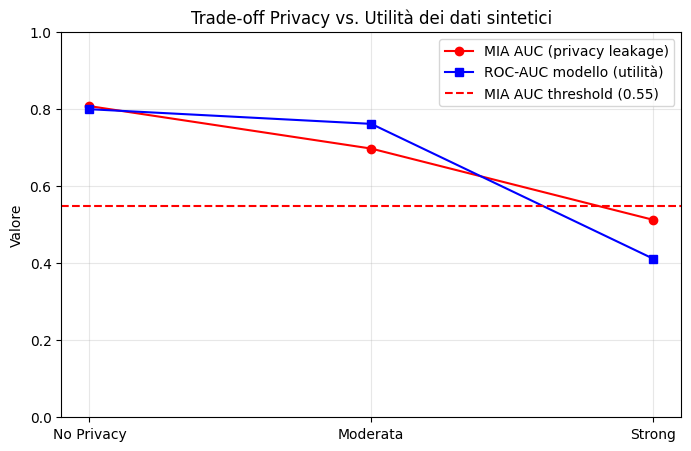

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i CSV
mia_df = pd.read_csv("mia_results_summary.csv")
model_df = pd.read_csv("model_performance.csv")

# Ordina livelli di privacy
privacy_levels = ["CTGAN_no_privacy", "Privacy moderata", "Privacy strong"]
x_labels = ["No Privacy", "Moderata", "Strong"]

# Allinea dati
mia_auc = [mia_df[mia_df['Generatore'] == lvl]['auc'].values[0] for lvl in privacy_levels]
model_roc = [
    model_df[model_df['privacy_level'].str.contains("no privacy")]['roc_auc'].values[0],
    model_df[model_df['privacy_level'].str.contains("moderate")]['roc_auc'].values[0],
    model_df[model_df['privacy_level'].str.contains("strong")]['roc_auc'].values[0]
]

# Soglia MIA per considerare privacy non passata
mia_threshold = 0.55

# Crea il grafico
plt.figure(figsize=(8,5))
plt.plot(x_labels, mia_auc, 'o-', color='red', label='MIA AUC (privacy leakage)')
plt.plot(x_labels, model_roc, 's-', color='blue', label='ROC-AUC modello (utilità)')

# Linea tratteggiata soglia MIA
plt.axhline(y=mia_threshold, color='red', linestyle='--', label=f'MIA AUC threshold ({mia_threshold})')

plt.ylim(0,1)
plt.ylabel("Valore")
plt.title("Trade-off Privacy vs. Utilità dei dati sintetici")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
